In [1]:
from __future__ import division, print_function

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['lines.linewidth'] = 0.75

import numpy as np
import pandas as pd
def df_repr_latex(self):
    return '\n'.join([
        r'\vspace{5mm}',
        r'{\scriptsize{\centering{%s}}}' % self.to_latex(),
        r'\vspace{5mm}'
    ])
pd.DataFrame._repr_latex_ = df_repr_latex
from pandas.formats.style import Styler
Styler._repr_latex_ = lambda s: s.data._repr_latex_()

class HTMLLatex:
    def __init__(self, html, latex):
        self.html = html
        self.latex = latex
    def _repr_html_(self): return self.html
    def _repr_latex_(self): return self.latex
NewPage = HTMLLatex('<hr>', r'\clearpage\newpage')

from IPython.display import display, HTML, Latex

from dcmfetch import fetch_series
from mriqa.reports import (
    ghosting_report, slice_profile_report, distortion_report,
    resolution_bars_report, uniformity_report, snr_report
)

from mriqa.xmlqa.coilqa import (
    find_qa_results_file,
    coil_snr, coil_snr_history, coil_name, coil_names,
    plot_coil_images, 
    MINCOILSERNO
)

from dcmextras.siemenscsa import csa

# Percent above specification
MARGIN = 5 
margin_colour = lambda x: 'color: %s' % ('green' if x>= MARGIN else 'orange' if x>0 else 'red')
ok_colour     = lambda x: 'color: %s' % ('green' if x else 'red')

from datetime import datetime

import fmriqa

# MRI Physics QA - BCH Level 3 Aera
- Tests Performed:
  - Slice shape and Profile
  - Distortion and Field of View
  - In Plane Resolution
  - Ghosting
  - Head Coil SNR
  - Head Coil Image Uniformity

All of the above are acceptable.

In [2]:
text = '''
R. Hartley-Davies, J. Delve. S. Curtis, H. Elbert
Medical Physics & Bioengineering, UH Bristol
January 2019
'''
display(HTMLLatex(
    r'<pre>' + text + r'</pre>',
    r'\vfill' + '\n' + r'\begin{verbatim}' + '\n' + text + '\n' + r'\end{verbatim}' + '\n'
))


In [3]:
NewPage

## Slice Profile

These are the profiles of 3mm and 5mm slices in a conventional spin echo with a of T<sub>E</sub> of 30ms.

### 3 mm Slice

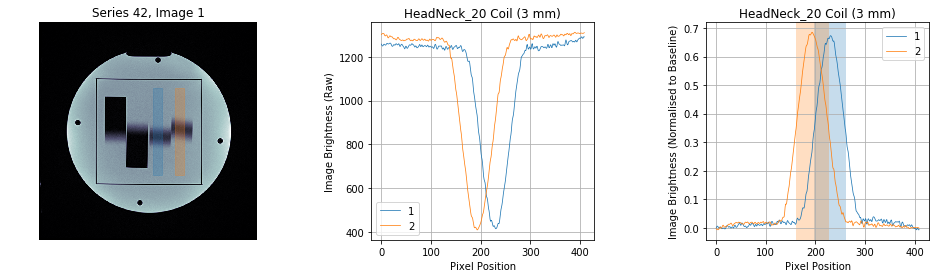

Plate Angle  =  11.7 degrees
FWHM     (1) =  64.0 pixels, or 3.2 mm
FWHM     (2) =  66.2 pixels, or 3.3 mm
FWHM (GMEAN) =  65.1 pixels, or 3.3 mm


In [4]:
# TO2: Slice 3mm
patid = 'PQA20181213BCH3Y'
stuid = '1'

# Distortion Corrected, Phase RL, Uniformity Corrected 512*512
dobjs = fetch_series(patid, stuid, sernos=[42])
slice_idx = 0
results = slice_profile_report(dobjs[slice_idx], flipped_ud=False, flipped_rl=False)

### 5 mm Slice

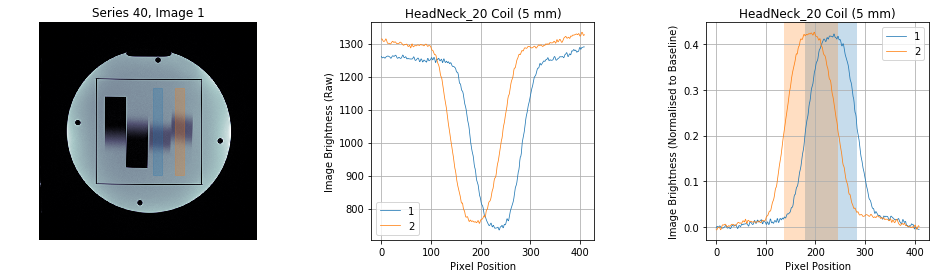

Plate Angle  =  11.7 degrees
FWHM     (1) =  104.6 pixels, or 5.3 mm
FWHM     (2) =  107.6 pixels, or 5.4 mm
FWHM (GMEAN) =  106.1 pixels, or 5.4 mm


In [5]:
# TO2: Slice 5mm
# Distortion Corrected, Phase RL, Uniformity Corrected 512*512
dobjs = fetch_series(patid, stuid, sernos=[40])
slice_idx = 0
result = slice_profile_report(dobjs[slice_idx], flipped_ud=False, flipped_rl=False)
results = results.append(result)

In [6]:
pd.set_option('precision', 1)
results[['FWHMGMeanPixels', 'FWHMGMeanMM']]

FWHMGMeanPixels  FWHMGMeanMM
SliceThickness                              
3.0                        65.1          3.3
5.0                       106.1          5.4

These are both with the AAPM tolerance of 0.5mm.

In [7]:
NewPage

## Geometric Distortion and Scaling

The TO2 phantom has a square box for distortion and scale measurements.

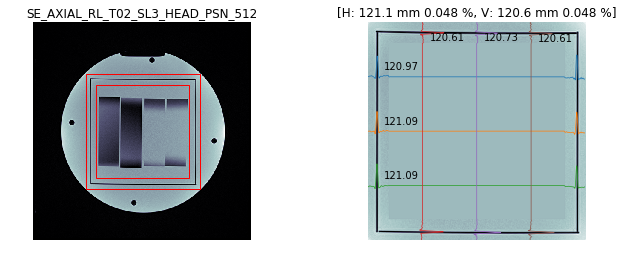

Horizontal Scale / Distortion:    121.1 mm / 0.05 %
Vertical Scale / Distortion:      120.6 mm / 0.05 %


In [8]:
# TO2: Distortion
# SE: Axial, Phase RL, 512 matrix
dobjs = fetch_series(patid, stuid, sernos=[42])

slice_idx = len(dobjs) // 2
results = distortion_report(dobjs[slice_idx], flipped_ud=False, flipped_rl=False)

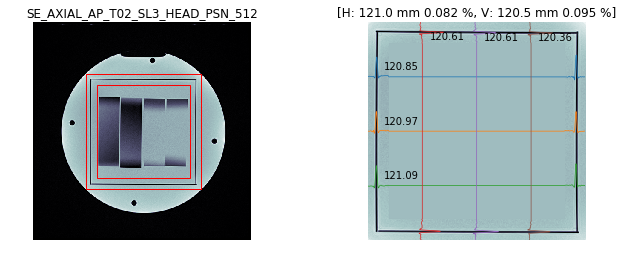

Horizontal Scale / Distortion:    121.0 mm / 0.08 %
Vertical Scale / Distortion:      120.5 mm / 0.10 %


In [9]:
# TO2: Distortion
# SE: Axial, Phase AP, 512 matrix

dobjs = fetch_series(patid, stuid, sernos=[44])

slice_idx = len(dobjs)//2
pd.set_option('precision', 3)
results = results.append(distortion_report(dobjs[slice_idx], flipped_ud=False, flipped_rl=False))

In [10]:
pd.set_option('precision', 3)
results[['Orientation', 'PhaseDirection', 'Sensitivity', 'HorizontalScale', 'HorizontalDistortion','VerticalScale', 'VerticalDistortion' ]]

Orientation PhaseDirection  Sensitivity  HorizontalScale  \
Series                                                            
42           Axial             RL        0.239          121.053   
44           Axial             AP        0.239          120.972   

        HorizontalDistortion  VerticalScale  VerticalDistortion  
Series                                                           
42                     0.048        120.646               0.048  
44                     0.082        120.524               0.095

The image scale is within 1% of the expected value. Distortion (arising from both gradient nonlinearity and field inhomogeneity) is acceptable at the bandwidth used (130Hz/pixel).

In [11]:
NewPage

## Spatial Resolution

The resolution is assessed using the TO4 phantom, which has parallel plates of various separations. These are results for the highest resolution scan (1024x10124).

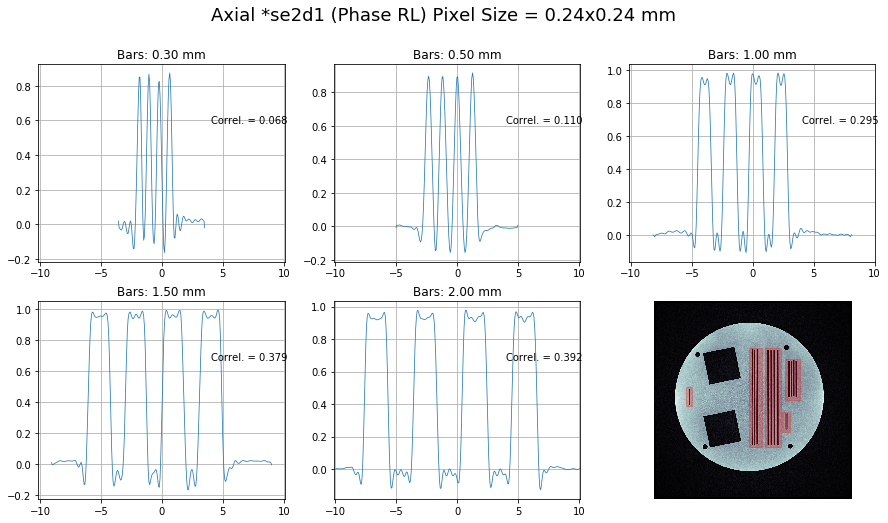

In [12]:
# TO4: Resolution
dobjs = fetch_series(patid, stuid, sernos=[50])
slice_idx = 0
result = resolution_bars_report(dobjs[slice_idx], flipped_ud=False, flipped_rl=True)

All the features are adequately resolved.

In [13]:
NewPage

## Ghosting

Image ghosting is asesssed following the approach of [AAPM report 100](https://www.aapm.org/pubs/reports/RPT_100.pdf) for the transverse orientation and three example sequences.

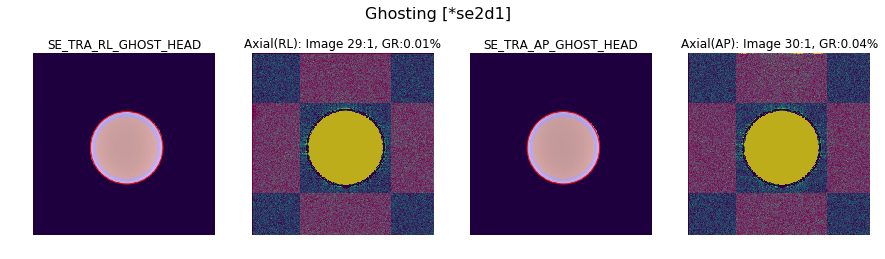

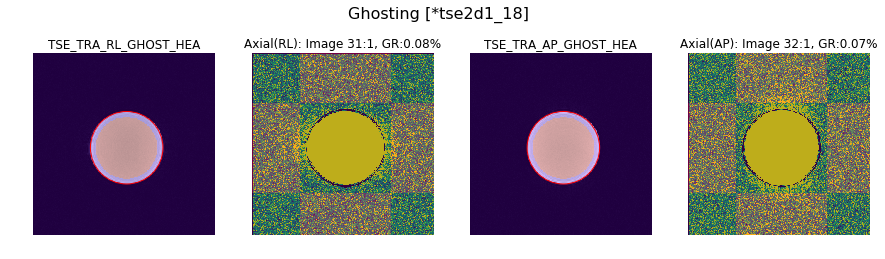

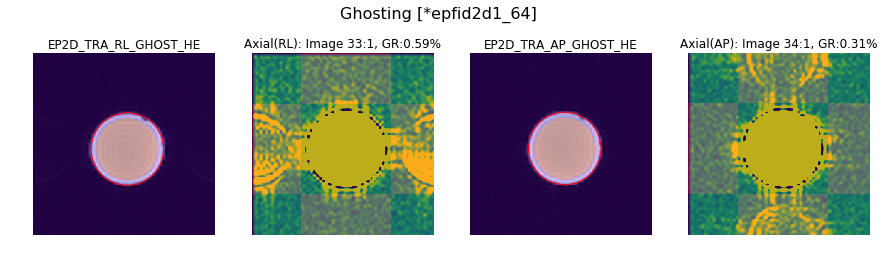

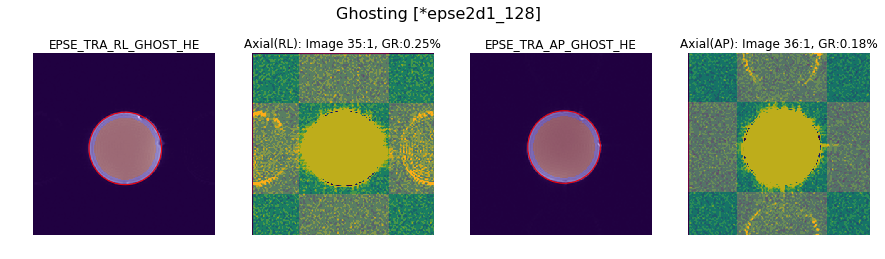

Sequence Orientation PhaseDirection  GhostRatio
Series                                                     
29            *se2d1       Axial             RL      0.0090
30            *se2d1       Axial             AP      0.0429
31        *tse2d1_18       Axial             RL      0.0760
32        *tse2d1_18       Axial             AP      0.0696
33      *epfid2d1_64       Axial             RL      0.5881
34      *epfid2d1_64       Axial             AP      0.3138
35      *epse2d1_128       Axial             RL      0.2488
36      *epse2d1_128       Axial             AP      0.1772

In [14]:
# GE10CM: Ghosting

# SE Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in [29, 30]]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = ghosting_report(dobjs, axes=list(axs.flat))

# TSE18 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in [31, 32]]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = results.append(ghosting_report(dobjs, axes=list(axs.flat)))

# EPI64 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in [33, 34]]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = results.append(ghosting_report(dobjs, axes=list(axs.flat)))
plt.show()

# EPISE128 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in [35, 36]]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = results.append(ghosting_report(dobjs, axes=list(axs.flat)))
plt.show()

pd.set_option('precision', 4)
display(results[['Sequence', 'Orientation', 'PhaseDirection', 'GhostRatio']])

The level of ghosting is low (less than 1% for SE, TSE, EPI and SE-EPI).

In [15]:
NewPage

## Receiver Coil Uniformity

We have tested the uniformity of the standard head/neck coil using a silicone oil filled spherical phantom. Results are presented both before and after Siemens `prescan-normalise` intensity correction.

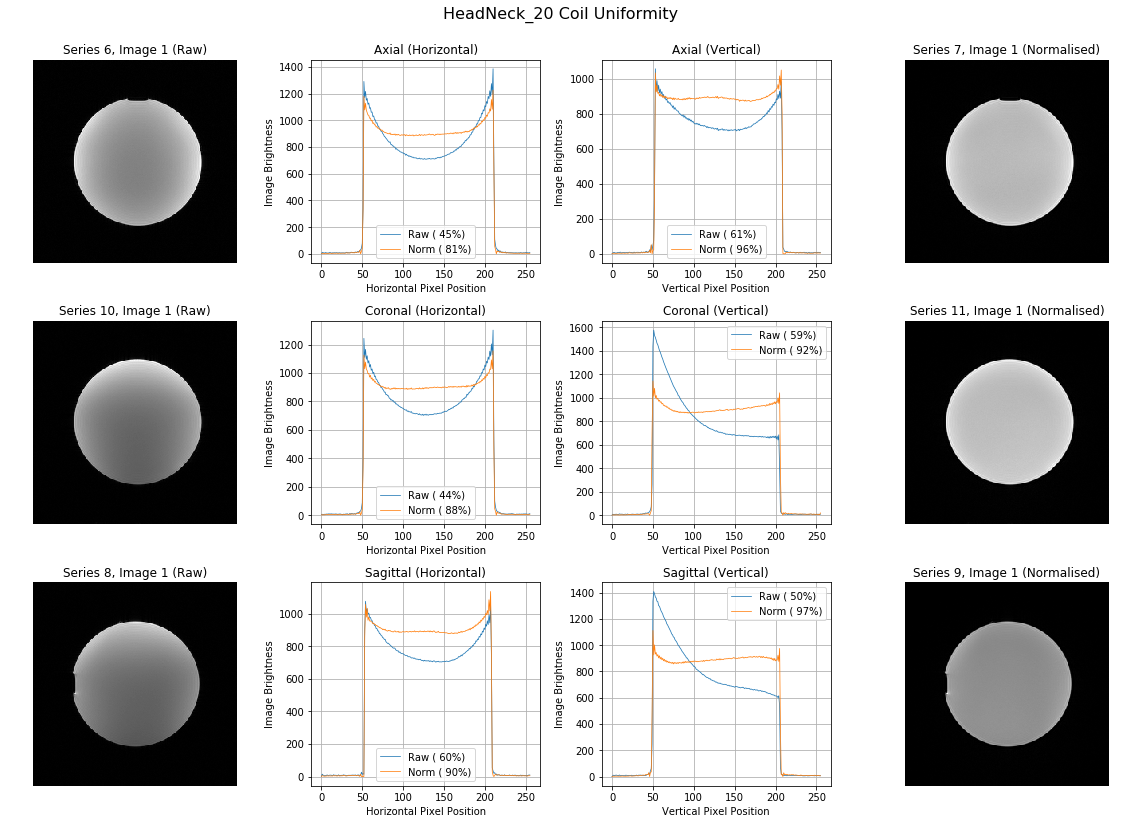

Raw Images


SeriesRaw                      ProtocolRaw    OrientRaw  \
Orientation                                                            
Axial                6  SE_TRA_RL_UNIF_HEAD_OIL20CM_PSN     Axial/RL   
Coronal             10  SE_COR_FH_UNIF_HEAD_OIL20CM_PSN   Coronal/HF   
Sagittal             8  SE_SAG_AP_UNIF_HEAD_OIL20CM_PSN  Sagittal/AP   

             XUniformityRaw  YUniformityRaw  
Orientation                                  
Axial                    45              61  
Coronal                  44              59  
Sagittal                 60              50

Intensity Normalised Images


SeriesNorm                     ProtocolNorm   OrientNorm  \
Orientation                                                             
Axial                 7  SE_TRA_RL_UNIF_HEAD_OIL20CM_PSN     Axial/RL   
Coronal              11  SE_COR_FH_UNIF_HEAD_OIL20CM_PSN   Coronal/HF   
Sagittal              9  SE_SAG_AP_UNIF_HEAD_OIL20CM_PSN  Sagittal/AP   

             XUniformityNorm  YUniformityNorm  
Orientation                                    
Axial                     81               96  
Coronal                   88               92  
Sagittal                  90               97

In [16]:
# OILSPHERE: Uniformity
# SE Axial,Coronal,Sagittal; w w/o Intensity Normalization
patid = 'PQA20181213BCH3Y'
stuid = '1'
raw_tra = fetch_series(patid, stuid, sernos=[6])
psn_tra = fetch_series(patid, stuid, sernos=[7])
raw_sag = fetch_series(patid, stuid, sernos=[8])
psn_sag = fetch_series(patid, stuid, sernos=[9])
raw_cor = fetch_series(patid, stuid, sernos=[10])
psn_cor = fetch_series(patid, stuid, sernos=[11])

if len(raw_tra) > 1:
    results = uniformity_report(
        raw_dobjs=[raw_tra[0], raw_sag[0], raw_cor[0]],
        psn_dobjs=[psn_tra[0], psn_sag[0], psn_cor[0]],
        raw_dobjsb=[raw_tra[1], raw_sag[1], raw_cor[1]],
        psn_dobjsb=[psn_tra[1], psn_sag[1], psn_cor[1]]
    )
else:
    results = uniformity_report(
        raw_dobjs=[raw_tra[0], raw_sag[0], raw_cor[0]],
        psn_dobjs=[psn_tra[0], psn_sag[0], psn_cor[0]],
    )

plt.show()

pd.set_option('precision', 0)
print('Raw Images')
display(results[['SeriesRaw',  'ProtocolRaw',  'OrientRaw', 'XUniformityRaw', 'YUniformityRaw']])
print('Intensity Normalised Images')
display(results[['SeriesNorm', 'ProtocolNorm', 'OrientNorm', 'XUniformityNorm', 'YUniformityNorm']])

As expected for a multi-element coil the uncorrected images are significantly non-uniform. However, the Siemens `prescan-normalise` intensity correction is adequate in compensating for this though there is some residual surface brightening in the horizontal direction as indicated by the slightly lower values for the uniformity in this direction.

In [17]:
NewPage

## Signal to Noise

The Siemens QA involves a comprehensive element by element assessment of the SNR of all the coils. For reference purposes the following is an independent estimate for the standard head/neck coil using the Siemens long bottle phantom (this can easily be positioned reproducibly). The SNR is estimated over centred discs with diameters 50% and 75% of the phantom. The signal is taken from the mean of two images within the phantom and noise estimated from a background region in their difference.

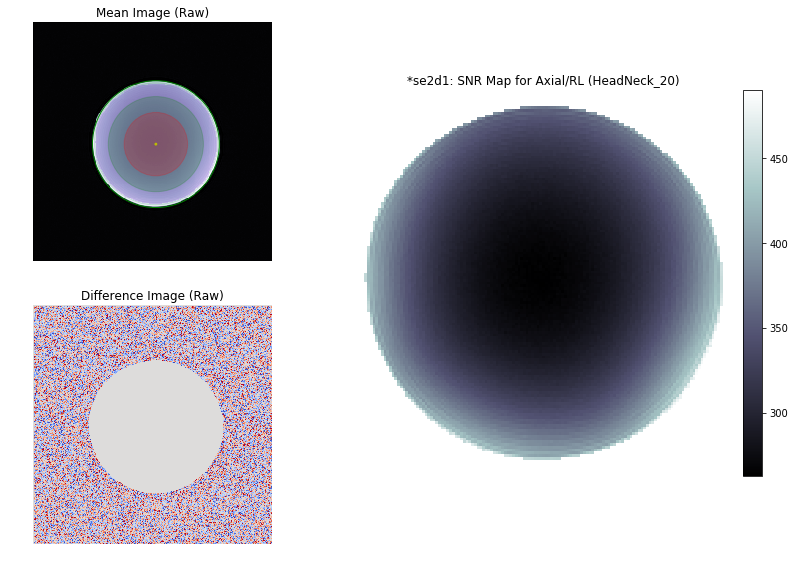

SNR: Raw Images


HeadNeck_20
RegionSize             
0.50              281.0
0.75              304.0

In [18]:
# LONGBOTTLE: Signal to Noise
patid = 'PQA20181213BCH3Y'
stuid = '1'
raw_tra = fetch_series(patid, stuid, sernos=[18, 20])
if len(raw_tra) > 1:
    results = snr_report(raw_dobjs=[raw_tra[0]], raw_dobjsb=[raw_tra[1]])
else:
    results = snr_report(raw_dobjs=[raw_tra[0]])
plt.show()

print('SNR: Raw Images')
pd.set_option('precision', 2)
display(np.round(results))

These results are similar to the those we have obtained on other 1.5T Siemens scanners under these conditions.

In [19]:
NewPage